In [44]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from scipy import stats
from scipy.stats import ttest_ind
from ISLP import load_data

# --- Matplotlib Extras ---
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# --- Sklearn Preprocessing & Pipeline ---
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- Sklearn Model Selection ---
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# --- Sklearn Models ---
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

# --- Sklearn Metrics ---
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
# ya que estaba en tu bloque original)
warnings.filterwarnings('ignore')


In [45]:
df = pd.read_csv('basefina2.csv')

### Realizamos un tratamiento en las variables que pueden generar problemas y reducimos la dimensionalidad de algunas de ellas
df.drop(['CAT_OCUP', 'CAT_INAC'], axis=1)
df.loc[df['IX_TOT'] >= 7, 'IX_TOT'] = 7
df.loc[df['IV2'] >= 7, 'IV2'] = 7
df['CH15'] = df['CH15'].replace(5.0, 4.0)
df['CH03'] = df['CH03'].replace([8.0, 9.0], 7.0)

A Enfoque de validación


Utilicen la base respondieron. Para cada año, dividan las observaciones en una base de prueba (test) y una de entrenamiento (train)
utilizando el comando train_test_split.
La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 444.
Establezca a pobre como su variable dependiente en la base de entrenamiento (vector y).
El resto de las variables seleccionadas serán las variables independientes (matriz X).
Recuerden agregar la columna de unos (1) para el intercepto.
Aclaración: no incluir la variable ingreso en X para predecir la pobreza
porque cuando vayamos a la base de norespondieron no vamos a tener esa información.

1. Cree una tabla de diferencia de medias entre la base de entrenamiento y la de testeo de las características seleccionadas en su matriz X. Para la matriz de las X seleccione variables que hayan limpiado en los TPs anteriores y justifique su inclusión para predecir la pobreza. Comente la tabla de la diferencia de medias de sus variables entre entrenamiento y testeo. ¿Hay diferencias significativas entre las medias del entrenamiento y testeo? 

2. Separen la base respondieron en dos: respondieron_2005 y respondieron_2025. Idem con la base norespondieron. 

In [46]:
# Filtrar filas donde 'ITF' fue respondida o no
df_noresp = df[df['ITF'] == 0].drop(columns='ITF')
df_resp = df[df['ITF'] != 0].drop(columns='ITF')

#Por AÑOS
respondieron_2005 = df_resp[df_resp['ANIO'] == 2005].drop(columns='ANIO')
respondieron_2025 = df_resp[df_resp['ANIO'] == 2025].drop(columns='ANIO')

#Por AÑOS
norespondieron_2005 = df_noresp[df_noresp['ANIO'] == 2005].drop(columns='ANIO')
norespondieron_2025 = df_noresp[df_noresp['ANIO'] == 2025].drop(columns='ANIO')

In [47]:
#2005
y_05 = respondieron_2005['pobre'].copy()
x_05 = respondieron_2005.drop(columns=['pobre']).copy()

#2025
y_25 = respondieron_2025['pobre'].copy()
x_25 = respondieron_2025.drop(columns=['pobre']).copy()

## Verifico las filas y los datos faltantes
print("Dimensiones de x_05:", x_05.shape)
print("Dimensiones de y_05:", y_05.shape)

print("Dimensiones de x_25:", x_25.shape)
print("Dimensiones de y_25:", y_25.shape)

# Hay valores faltantes?
print("\n Missings:\n", y_25.isnull().sum()) 
print("\n Missings:\n", y_05.isnull().sum())

Dimensiones de x_05: (8739, 23)
Dimensiones de y_05: (8739,)
Dimensiones de x_25: (8342, 23)
Dimensiones de y_25: (8342,)

 Missings:
 0

 Missings:
 0


In [48]:
x_05.columns

Index(['AGLOMERADO', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'CH09', 'CH15',
       'es_estudiante', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'IV1', 'IV2', 'IV6',
       'IV8', 'II8', 'IX_TOT', 'V2', 'V14', 'EDUC', 'horastrab', 'EDAD_2'],
      dtype='object')

In [49]:
#union_eph_resp_2005 
x_train_2005, x_test_2005, y_train_2005, y_test_2005 = train_test_split(x_05, y_05, test_size=0.7, random_state=444)

#union_eph_resp_2025
x_train_25, x_test_25, y_train_2025, y_test_2025 = train_test_split(x_25, y_25, test_size=0.7, random_state=444)

In [50]:
###### diferencias de medias. 

def tabla_diferencia_medias(x_train, x_test, columnas):
    # Filtramos solo las columnas relevantes
    x_train_filtrado = x_train[columnas]
    x_test_filtrado = x_test[columnas]
    
    # Calculamos medias
    medias_train = x_train_filtrado.mean()
    medias_test = x_test_filtrado.mean()
    
    # Creamos tabla
    tabla = pd.DataFrame({
        'Media Train': medias_train,
        'Media Test': medias_test,
        'Diferencia (Train - Test)': medias_train - medias_test
    })
    
    return tabla.round(4)


tabla_x05 = tabla_diferencia_medias(x_train_2005, x_test_2005, x_train_2005.columns)
tabla_x05

,Media Train,Media Test,Diferencia (Train - Test)
AGLOMERADO,23.2816,23.2891,-0.0076
CH03,2.7608,2.7816,-0.0208
CH04,0.4880,0.4835,0.0045
CH06,29.6372,29.6249,0.0123
CH07,3.7478,3.7777,-0.0299
CH08,0.5441,0.5482,-0.0042
CH09,1.1396,1.1332,0.0064
CH15,1.3804,1.3733,0.0071
es_estudiante,0.2911,0.2893,0.0018
ESTADO,2.4662,2.4235,0.0427


In [51]:
###### diferencias de medias. 

def tabla_diferencia_medias(x_train, x_test, columnas):
    # Filtramos solo las columnas relevantes
    x_train_filtrado = x_train[columnas]
    x_test_filtrado = x_test[columnas]
    
    # Calculamos medias
    medias_train = x_train_filtrado.mean()
    medias_test = x_test_filtrado.mean()
    
    # Creamos tabla
    tabla = pd.DataFrame({
        'Media Train': medias_train,
        'Media Test': medias_test,
        'Diferencia (Train - Test)': medias_train - medias_test
    })
    
    return tabla.round(4)


tabla_x25 = tabla_diferencia_medias(x_train_25, x_test_25, x_train_2005.columns)
tabla_x25

,Media Train,Media Test,Diferencia (Train - Test)
AGLOMERADO,22.8078,22.8122,-0.0044
CH03,2.6119,2.5991,0.0128
CH04,0.4764,0.4863,-0.0099
CH06,35.1175,34.7764,0.3411
CH07,3.7574,3.7435,0.0139
CH08,0.6543,0.6387,0.0156
CH09,1.0655,1.0709,-0.0053
CH15,1.2710,1.2812,-0.0102
es_estudiante,0.2734,0.2709,0.0025
ESTADO,2.2382,2.2622,-0.0239


In [52]:
# Armo un test de diferencia de medias.
# Esto crea un DataFrame donde CADA FILA es una feature
# Asume que todas las columnas en x_train/x_test son numéricas
# Usamos numeric_only=True por si acaso
estadisticos_x = pd.DataFrame({
    'Mean train': x_train_2005.mean(numeric_only=True),
    'sd train': x_train_2005.std(numeric_only=True),
    'Mean test': x_test_2005.mean(numeric_only=True),
    'sd test': x_test_2005.std(numeric_only=True),
    'N train': x_train_2005.shape[0], # N es el mismo para todas
    'N test': x_test_2005.shape[0]  # N es el mismo para todas
})

# --- 2. Calcular T-test y P-value para CADA feature en X ---
# Creamos diccionarios para guardar los resultados
t_stats_x = {}
p_values_x = {}

# Itera SOLO sobre las columnas numéricas que están en el DataFrame
for col in estadisticos_x.index:
    t_stat, p_value = stats.ttest_ind(
        x_train_2005[col].dropna(), 
        x_test_2005[col].dropna(), 
        equal_var=False  # Usar T-test de Welch (más seguro)
    )
    t_stats_x[col] = t_stat
    p_values_x[col] = p_value

# Añade los resultados al DataFrame de estadísticos
estadisticos_x['t-test'] = estadisticos_x.index.map(t_stats_x)
estadisticos_x['p-value'] = estadisticos_x.index.map(p_values_x)

estadisticos_final = pd.concat([estadisticos_x])

print("--- Estadísticos Completos 2005 ---")
estadisticos_final

--- Estadísticos Completos 2005 ---


,Mean train,sd train,Mean test,sd test,N train,N test,t-test,p-value
AGLOMERADO,23.281572,4.158051,23.289147,4.105434,2621,6118,-0.078331,0.937568
CH03,2.760778,1.523982,2.781628,1.558213,2621,6118,-0.582087,0.560534
CH04,0.487982,0.499951,0.483491,0.499768,2621,6118,0.384776,0.700420
CH06,29.637161,21.129209,29.624877,21.096569,2621,6118,0.024915,0.980124
CH07,3.747806,1.569059,3.777705,1.550716,2621,6118,-0.819112,0.412762
CH08,0.544067,0.498149,0.548218,0.497710,2621,6118,-0.357058,0.721064
CH09,1.139641,0.396016,1.133213,0.395832,2621,6118,0.695382,0.486849
CH15,1.380389,0.737686,1.373325,0.726360,2621,6118,0.412111,0.680276
es_estudiante,0.291110,0.454361,0.289310,0.453479,2621,6118,0.169801,0.865174
ESTADO,2.466234,1.158154,2.423504,1.151702,2621,6118,1.583059,0.113472


In [53]:
# Armo un test de diferencia de medias.
# Esto crea un DataFrame donde CADA FILA es una feature
# Asume que todas las columnas en x_train/x_test son numéricas
# Usamos numeric_only=True por si acaso
estadisticos_x = pd.DataFrame({
    'Mean train': x_train_25.mean(numeric_only=True),
    'sd train': x_train_25.std(numeric_only=True),
    'Mean test': x_test_25.mean(numeric_only=True),
    'sd test': x_test_25.std(numeric_only=True),
    'N train': x_train_25.shape[0], # N es el mismo para todas
    'N test': x_test_25.shape[0]  # N es el mismo para todas
})

# --- 2. Calcular T-test y P-value para CADA feature en X ---
# Creamos diccionarios para guardar los resultados
t_stats_x = {}
p_values_x = {}

# Itera SOLO sobre las columnas numéricas que están en el DataFrame
for col in estadisticos_x.index:
    t_stat, p_value = stats.ttest_ind(
        x_train_25[col].dropna(), 
        x_test_25[col].dropna(), 
        equal_var=False  # Usar T-test de Welch (más seguro)
    )
    t_stats_x[col] = t_stat
    p_values_x[col] = p_value

# Añade los resultados al DataFrame de estadísticos
estadisticos_x['t-test'] = estadisticos_x.index.map(t_stats_x)
estadisticos_x['p-value'] = estadisticos_x.index.map(p_values_x)

estadisticos_final = pd.concat([estadisticos_x])

print("--- Estadísticos Completos 2025  ---")
estadisticos_final

--- Estadísticos Completos 2025  ---


,Mean train,sd train,Mean test,sd test,N train,N test,t-test,p-value
AGLOMERADO,22.807754,3.685374,22.812158,3.734807,2502,5840,-0.049808,0.960277
CH03,2.611910,1.543474,2.599144,1.518319,2502,5840,0.347863,0.727959
CH04,0.476419,0.499543,0.486301,0.499855,2502,5840,-0.827804,0.407823
CH06,35.117506,21.297285,34.776370,21.693824,2502,5840,0.666629,0.505041
CH07,3.757394,1.597146,3.743493,1.603417,2502,5840,0.363833,0.715999
CH08,0.654277,0.475699,0.638699,0.480419,2502,5840,1.366464,0.171858
CH09,1.065548,0.275081,1.070890,0.291059,2502,5840,-0.798689,0.424509
CH15,1.270983,0.651107,1.281164,0.665538,2502,5840,-0.650071,0.515677
es_estudiante,0.273381,0.445784,0.270890,0.444458,2502,5840,0.234062,0.814947
ESTADO,2.238209,1.126190,2.262158,1.127255,2502,5840,-0.889716,0.373664


B. Modelo de Regresion Logística

3. Estimación y Efectos Marginales: Estimen una Regresión Logística usando X_train de respondieron_2025. Exporten una tabla con: (i) los coeficientes estimados para cada variable, (ii) los errores estándar y (ii) los odd-ratios. Interpreten los resultados de la tabla. (Hint: en la clase 6 hay una ilustración de la tabla).

In [54]:
### Codifico las variables categoricas y estandarizo las variables numericas
var_cat = ['AGLOMERADO', 'CH03', 'CH04','CH07', 'CH08', 'CH09', 'CH15',
       'es_estudiante', 'ESTADO', 'IV1', 'IV2', 'IV6',
       'IV8', 'II8', 'IX_TOT', 'V2', 'V14',]

var_num = ['CH06','EDUC', 'horastrab', 'EDAD_2']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# --- 3. Creamos el "jefe" preprocesador ---
preprocessor = ColumnTransformer(
    transformers=[
        # Instrucción A: "Aplica el paquete numérico a estas columnas"
        ('num', numeric_transformer, var_num),
        
        # Instrucción B: "Aplica el OneHotEncoder a estas columnas"
        ('cat', OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore'), var_cat)
    ],

    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")
x_train_2025 = preprocessor.fit_transform(x_train_25)
x_test_2025 = preprocessor.transform(x_test_25)

df_noresp_25 = preprocessor.transform(norespondieron_2025)

In [55]:
# Añadimos el intercepto
x_train_2025 = sm.add_constant(x_train_2025)
x_test_2025  = sm.add_constant(x_test_2025) 
x_train_2025

,const,CH06,EDUC,horastrab,EDAD_2,AGLOMERADO_19.0,AGLOMERADO_22.0,AGLOMERADO_23.0,AGLOMERADO_25.0,AGLOMERADO_29.0,...,IV8_2.0,II8_1.0,IX_TOT_2.0,IX_TOT_3.0,IX_TOT_4.0,IX_TOT_5.0,IX_TOT_6.0,IX_TOT_7.0,V2_2.0,V14_2.0
12524,1.0,-1.038721,-0.185183,-0.743399,-0.872914,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
11395,1.0,0.370191,0.035239,1.693160,0.093391,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9076,1.0,-0.146410,0.696508,1.880587,-0.381134,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10604,1.0,0.370191,0.476085,-0.743399,0.093391,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8903,1.0,-0.991757,-0.405606,-0.743399,-0.857384,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12288,1.0,-1.320503,-1.728144,-0.743399,-0.941936,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
16207,1.0,1.215538,-0.626029,1.224591,1.170131,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
9815,1.0,-0.616047,0.255662,0.381167,-0.691732,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12430,1.0,1.919994,-0.626029,-0.743399,2.352129,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [56]:

logit_model = sm.Logit(y_train_2025.astype(float),x_train_2025.astype(float))
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.526596
         Iterations 6
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: pobre            Pseudo R-squared: 0.237      
Date:               2025-11-11 09:58 AIC:              2739.0844  
No. Observations:   2502             BIC:              3041.9763  
Df Model:           51               Log-Likelihood:   -1317.5    
Df Residuals:       2450             LL-Null:          -1726.4    
Converged:          1.0000           LLR p-value:      8.9410e-139
No. Iterations:     6.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -0.0717   0.4885  -0.1467 0.8834 -1.0292  0.8858
CH06               0.6391   0.4230   1.5110 0.1308 -0

In [57]:
# Ajustamos el clasificador con el método fit() 
log_reg = LogisticRegression(penalty=None).fit(x_train_2025, y_train_2025)

In [58]:
coef = result.params
std_err = result.bse
odds_ratios = np.exp(coef)

# Creo un DataFrame combinado con los 3
df_expo = pd.DataFrame({
    'Coeficiente': coef,
    'Error estándar': std_err,
    'Odds Ratio': odds_ratios
})
df_expo

,Coeficiente,Error estándar,Odds Ratio
const,-0.071673,0.488526,0.930835
CH06,0.639095,0.422964,1.894766
EDUC,-0.447640,0.082323,0.639135
horastrab,-0.382377,0.101972,0.682238
EDAD_2,-1.036255,0.379919,0.354781
AGLOMERADO_19.0,-0.475381,0.178120,0.621648
AGLOMERADO_22.0,-0.009454,0.181068,0.990591
AGLOMERADO_23.0,-0.192366,0.175650,0.825005
AGLOMERADO_25.0,0.091703,0.195621,1.096039
AGLOMERADO_29.0,-0.083023,0.182848,0.920330


In [59]:
df_expo

,Coeficiente,Error estándar,Odds Ratio
const,-0.071673,0.488526,0.930835
CH06,0.639095,0.422964,1.894766
EDUC,-0.447640,0.082323,0.639135
horastrab,-0.382377,0.101972,0.682238
EDAD_2,-1.036255,0.379919,0.354781
AGLOMERADO_19.0,-0.475381,0.178120,0.621648
AGLOMERADO_22.0,-0.009454,0.181068,0.990591
AGLOMERADO_23.0,-0.192366,0.175650,0.825005
AGLOMERADO_25.0,0.091703,0.195621,1.096039
AGLOMERADO_29.0,-0.083023,0.182848,0.920330


4. Visualización: Grafiquen la P ̂(Y=1|X) (en el eje vertical) y alguna característica numérica (en el eje horizontal). Comente dicho gráfico y la variable seleccionada para ilustrar la probabilidad de ser pobre según la característica seleccionada. (Hint: en la clase 6 hay una ilustración de este estilo).



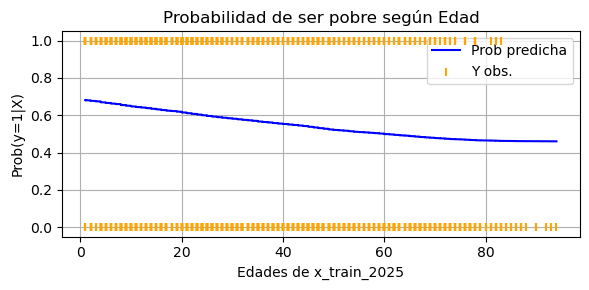

In [60]:
# Suponiendo que x_train_2025 y y_train_2025 ya están definidos y son DataFrames/arrays válidos
x_train_2025_ch06 = x_train_25[['CH06']].astype(float)
y_train_2025 = np.array(y_train_2025).flatten()

# Crear y ajustar el modelo
logit_model2 = LogisticRegression(penalty=None,fit_intercept=True)  
logit_model2.fit(x_train_2025_ch06, y_train_2025)

# Obtener las probabilidades predichas
y_pred_score_sm = logit_model2.predict_proba(x_train_2025_ch06)[:, 1]

# Ordenar los valores de X
x_sorted = np.sort(x_train_2025_ch06, axis=0).flatten()

# Calcular las probabilidades acumuladas
y_pred_score_sorted = logit_model2.predict_proba(x_sorted.reshape(-1, 1))[:, 1]
probabilidad_acumulada = np.cumsum(y_pred_score_sorted) / np.arange(1, len(y_pred_score_sorted) + 1)

# Gráfico de resultados
plt.figure(figsize=(6,3))

plt.plot(x_sorted, probabilidad_acumulada, color='blue', zorder=10, label='Prob predicha')
plt.scatter(x_train_2025_ch06, y_train_2025, color='orange', zorder=20, marker="|", label='Y obs.' )
plt.xlabel('Edades de x_train_2025')
plt.ylabel('Prob(y=1|X)')
plt.legend()
plt.title('Probabilidad de ser pobre según Edad')
plt.grid()  # Añadir una cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout para que no se corten los elementos
plt.show()

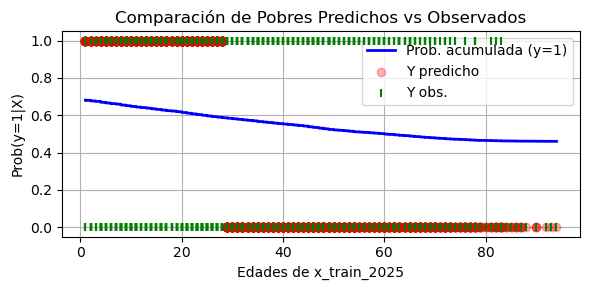

In [61]:
plt.figure(figsize=(6, 3))

# Probabilidades predichas ordenadas por edad
y_pred_score_sorted = logit_model2.predict_proba(x_sorted.reshape(-1,1))[:,1]

# Probabilidad acumulada conforme crece la edad
probabilidad_acumulada = np.cumsum(y_pred_score_sorted) / np.arange(1, len(y_pred_score_sorted) + 1)

y_pred_proba = logit_model2.predict(x_train_2025_ch06)

# Gráfico
plt.plot(x_sorted, probabilidad_acumulada, color='blue', linewidth=2, label='Prob. acumulada (y=1)')

plt.scatter(x_train_2025_ch06, y_pred_proba, color='red', alpha=0.3, zorder=20, label='Y predicho')
plt.scatter(x_train_2025_ch06, y_train_2025, color='green', zorder=20, marker="|", label='Y obs.')

plt.xlabel('Edades de x_train_2025')
plt.ylabel('Prob(y=1|X)')
plt.legend()
plt.title('Comparación de Pobres Predichos vs Observados')
plt.grid()
plt.tight_layout()
plt.show()

C. Método de Vecinos Cercanos (KNN)

5.	Estimación: Clasifiquen a las observaciones como “pobre”/“no pobre” en su región con Vecinos Cercanos (KNN) usando  K={1,5,10} para su matriz x_train de respondieron_2025. Expliquen en no más de 2-3 oraciones cómo la elección de K se relaciona con el trade-off sesgo varianza.

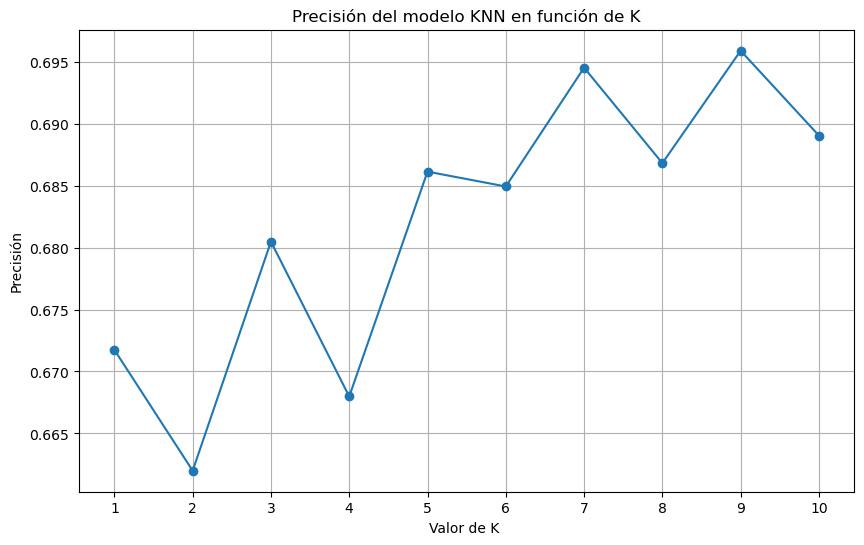

In [62]:
k_range = [1,2,3,4,5,6,7,8,9, 10]
scores_list = []

# Entrenamos el modelo y calculamos la precisión para cada k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_2025, y_train_2025)
    y_test_pred_knn = knn.predict(x_test_2025)  # Predicciones
    
    # Calcula la precisión
    accuracy = accuracy_score(y_test_2025, y_test_pred_knn)
    scores_list.append(accuracy)  

plt.figure(figsize=(10, 6))
plt.plot(k_range, scores_list, marker='o')  
plt.title('Precisión del modelo KNN en función de K')
plt.xlabel('Valor de K ')
plt.ylabel('Precisión')
plt.xticks(k_range)  # para mostrar todos los valores de k
plt.grid()  # cuadrícula para facilitar la lectura
plt.show()  

6.	Visualización: Grafiquen dos características numéricas de su matriz X_train y visualicen las clases predichas por KNN usando con K=(1,10) con su frontera por clase “pobre”/“no pobre”.

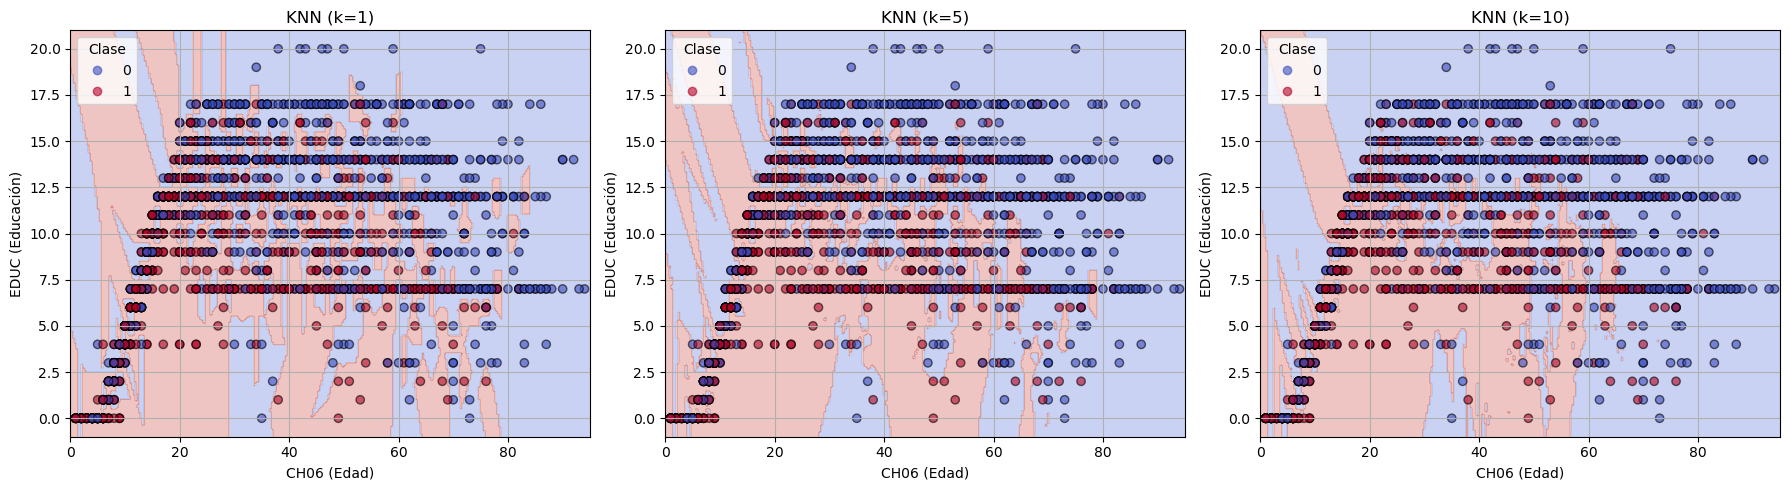

In [63]:
X = x_train_25[["CH06", "EDUC"]].values
y = y_train_2025  # 0 = no pobre, 1 = pobre

import numpy as np

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # CH06
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # EDUC
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]


import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ks = [1, 5, 10]
titles = [f"KNN (k={k})" for k in ks]

for ax, k, title in zip(axes, ks, titles):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X, y)
    Z = model.predict(grid).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("CH06 (Edad)")
    ax.set_ylabel("EDUC (Educación)")
    ax.grid()
    ax.legend(*scatter.legend_elements(), title="Clase")

plt.tight_layout()

7.	K optimo por Cross-validation: Dividan la base x_train de respondieron_2025 en 5 partes (5-fold) para obtener el K óptimo por 
Cross-Validation con K=(1,10). Llamenle a este modelo KNN con K-CV. 
Grafiquen el accuracy de cada modelo y comenten cual es el número óptimo de vecinos cercanos para identificar pobres.

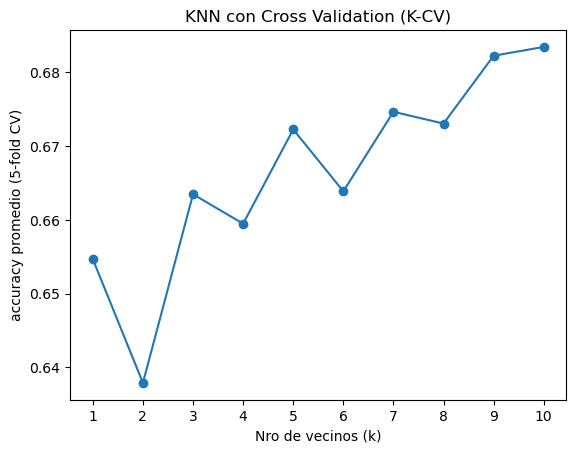

El K óptimo es 10 con accuracy promedio de 0.683


In [64]:
# Variables de entrenamiento
X = x_train_2025
y = y_train_2025

# Rango de k
k_range = range(1, 11)
cv_scores = []

# Validación cruzada 5-fold
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Graficar resultados
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel('Nro de vecinos (k)')
plt.ylabel('accuracy promedio (5-fold CV)')
plt.title('KNN con Cross Validation (K-CV)')
plt.xticks(k_range)
plt.show()

# Mejor k
best_k = k_range[np.argmax(cv_scores)]
print(f"El K óptimo es {best_k} con accuracy promedio de {max(cv_scores):.3f}")

D. Modelo de Regresión Logística con Regularización: Ridge y LASSOVisualización: 

    
8. Grafiquen en dos paneles distintos los coeficientes de la penalidad de LASSO y Ridge para la grilla de parámetros de penalidad $\lambda = 10^n$ con $n \in \{-5, -4, -3, \dots, 4, 5\}$ e interpreten la regularización con cada penalidad. (Hint: en la función LogisticRegression la opción C es la inversa de la fuerza de penalidad, en lugar de alpha. Según el tamaño de su matriz, se recomienda probar con distintas opciones de solver para el uso eficiente computacional).

Entrenando modelos para diferentes valores de lambda...
  λ = 1e-05, C = 100000.000000
  λ = 1e-04, C = 10000.000000
  λ = 1e-03, C = 1000.000000
  λ = 1e-02, C = 100.000000
  λ = 1e-01, C = 10.000000
  λ = 1e+00, C = 1.000000
  λ = 1e+01, C = 0.100000
  λ = 1e+02, C = 0.010000
  λ = 1e+03, C = 0.001000
  λ = 1e+04, C = 0.000100
  λ = 1e+05, C = 0.000010


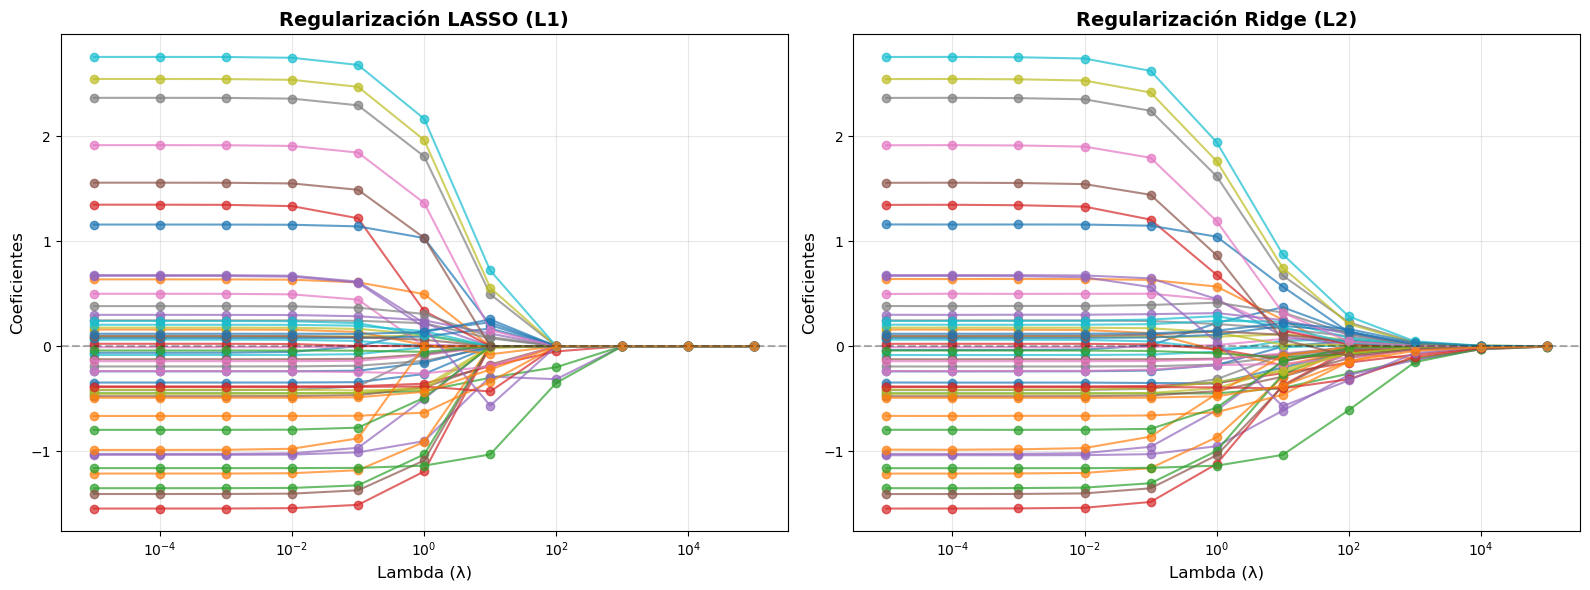

In [65]:
# Valores de lambda (C es la inversa de lambda)
lambdas = 10.0**np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
C_values = 1/lambdas

# Almacenar coeficientes
coef_lasso = []
coef_ridge = []

print("Entrenando modelos para diferentes valores de lambda...")

# Entrenar modelos para cada C
for i, C in enumerate(C_values):
    print(f"  λ = {lambdas[i]:.0e}, C = {C:.6f}")
    
    # LASSO (L1)
    model_lasso = LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                     max_iter=1000, random_state=42)
    model_lasso.fit(x_train_2025, y_train_2025)
    coef_lasso.append(model_lasso.coef_[0])
    
    # Ridge (L2)
    model_ridge = LogisticRegression(penalty='l2', C=C, solver='liblinear',
                                     max_iter=1000, random_state=42)
    model_ridge.fit(x_train_2025, y_train_2025)
    coef_ridge.append(model_ridge.coef_[0])

# Convertir a arrays
coef_lasso = np.array(coef_lasso)
coef_ridge = np.array(coef_ridge)

# Crear gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LASSO
for i in range(coef_lasso.shape[1]):
    axes[0].plot(lambdas, coef_lasso[:, i], marker='o', alpha=0.7)
axes[0].set_xscale('log')
axes[0].set_xlabel('Lambda (λ)', fontsize=12)
axes[0].set_ylabel('Coeficientes', fontsize=12)
axes[0].set_title('Regularización LASSO (L1)', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].grid(True, alpha=0.3)

# Ridge
for i in range(coef_ridge.shape[1]):
    axes[1].plot(lambdas, coef_ridge[:, i], marker='o', alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_xlabel('Lambda (λ)', fontsize=12)
axes[1].set_ylabel('Coeficientes', fontsize=12)
axes[1].set_title('Regularización Ridge (L2)', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

  8. Penalidad óptima por Cross-validation y visualización: Usando LogisticRegressionCV dividiendo la base 5 partes (5-fold), elijan la penalidad óptima $\lambda$ en la grilla mencionada arriba. ¿Qué $\lambda^{cv}$ seleccionó en cada caso? Generen plots mostrando la distribución del error de predicción para cada $\lambda$. Cada punto debe corresponder a un valor de $\lambda$ y contener como observaciones el error de clasificación de validación para cada partición. Opcional: para la regularización LASSO, generen un plot similar, pero graficando la proporción de variables ignoradas por el modelo en función de $\lambda$, es decir la proporción de variables para las cuales el coeficiente asociado es cero.


CROSS-VALIDATION PARA ENCONTRAR λ ÓPTIMA

Entrenando LASSO con 5-fold CV para cada λ...
Entrenando Ridge con 5-fold CV para cada λ...

✓ λ óptima LASSO: 0.100000 (C = 10.000000)
  Error medio: 0.2854

✓ λ óptima Ridge: 0.100000 (C = 10.000000)
  Error medio: 0.2854

Calculando proporción de variables eliminadas para cada λ...


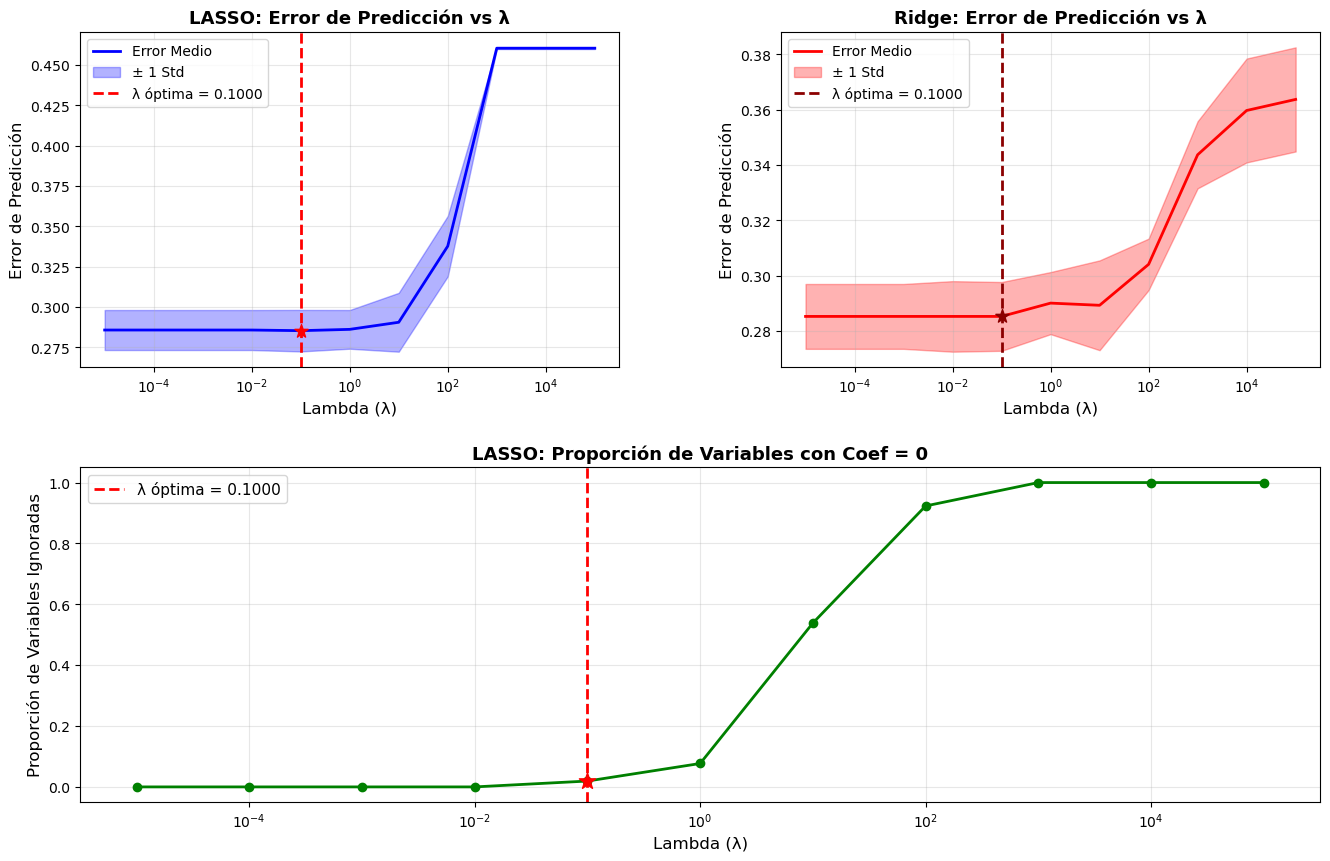

In [66]:
# Valores de C a probar (inversa de lambda)
C_values = 10.0**np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
lambdas_cv = 1.0 / C_values

print("\n" + "="*60)
print("CROSS-VALIDATION PARA ENCONTRAR λ ÓPTIMA")
print("="*60)

# Almacenar scores para cada lambda y cada fold
scores_lasso_by_lambda = []
scores_ridge_by_lambda = []

# LASSO: Evaluar cada lambda con CV
print("\nEntrenando LASSO con 5-fold CV para cada λ...")
for C in C_values:
    model = LogisticRegression(C=C, penalty='l1', solver='liblinear', 
                               max_iter=1000, random_state=42)
    cv_results = cross_validate(model, x_train_2025, y_train_2025, 
                                cv=5, scoring='accuracy', return_train_score=False)
    scores_lasso_by_lambda.append(cv_results['test_score'])

scores_lasso_by_lambda = np.array(scores_lasso_by_lambda)  # Shape: (n_lambdas, 5)

# RIDGE: Evaluar cada lambda con CV
print("Entrenando Ridge con 5-fold CV para cada λ...")
for C in C_values:
    model = LogisticRegression(C=C, penalty='l2', solver='liblinear', 
                               max_iter=1000, random_state=42)
    cv_results = cross_validate(model, x_train_2025, y_train_2025, 
                                cv=5, scoring='accuracy', return_train_score=False)
    scores_ridge_by_lambda.append(cv_results['test_score'])

scores_ridge_by_lambda = np.array(scores_ridge_by_lambda)  # Shape: (n_lambdas, 5)

# CONVERTIR ACCURACY A ERROR
errors_lasso_by_lambda = 1 - scores_lasso_by_lambda
errors_ridge_by_lambda = 1 - scores_ridge_by_lambda

# Calcular medias y desviaciones estándar de ERRORES
mean_error_lasso = errors_lasso_by_lambda.mean(axis=1)
std_error_lasso = errors_lasso_by_lambda.std(axis=1)

mean_error_ridge = errors_ridge_by_lambda.mean(axis=1)
std_error_ridge = errors_ridge_by_lambda.std(axis=1)

# Encontrar lambda óptima (mínimo error medio)
idx_opt_lasso = np.argmin(mean_error_lasso)
idx_opt_ridge = np.argmin(mean_error_ridge)

lambda_opt_lasso = lambdas_cv[idx_opt_lasso]
lambda_opt_ridge = lambdas_cv[idx_opt_ridge]

print(f"\n✓ λ óptima LASSO: {lambda_opt_lasso:.6f} (C = {C_values[idx_opt_lasso]:.6f})")
print(f"  Error medio: {mean_error_lasso[idx_opt_lasso]:.4f}")

print(f"\n✓ λ óptima Ridge: {lambda_opt_ridge:.6f} (C = {C_values[idx_opt_ridge]:.6f})")
print(f"  Error medio: {mean_error_ridge[idx_opt_ridge]:.4f}")

# Calcular proporción de variables eliminadas para cada lambda
print("\nCalculando proporción de variables eliminadas para cada λ...")
prop_zeros = []

for C in C_values:
    model = LogisticRegression(C=C, penalty='l1', solver='liblinear',
                              random_state=42, max_iter=1000)
    model.fit(x_train_2025, y_train_2025)
    n_zeros = np.sum(np.abs(model.coef_[0]) < 1e-5)
    n_total = len(model.coef_[0])
    prop_zeros.append(n_zeros / n_total)

# TRES GRÁFICOS: 2 ARRIBA, 1 ABAJO
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])  # Arriba izquierda
ax2 = fig.add_subplot(gs[0, 1])  # Arriba derecha
ax3 = fig.add_subplot(gs[1, :])  # Abajo (ocupa las 2 columnas)

# GRÁFICO 1: LASSO - Error con sombreado
ax1.plot(lambdas_cv, mean_error_lasso, linewidth=2, color='blue', label='Error Medio')
ax1.fill_between(lambdas_cv, mean_error_lasso - std_error_lasso, 
                  mean_error_lasso + std_error_lasso, 
                  alpha=0.3, color='blue', label='± 1 Std')
ax1.axvline(lambda_opt_lasso, color='red', linestyle='--', linewidth=2, 
            label=f'λ óptima = {lambda_opt_lasso:.4f}')
ax1.scatter(lambda_opt_lasso, mean_error_lasso[idx_opt_lasso], 
            color='red', s=100, zorder=5, marker='*')
ax1.set_xscale('log')
ax1.set_xlabel('Lambda (λ)', fontsize=12)
ax1.set_ylabel('Error de Predicción', fontsize=12)
ax1.set_title('LASSO: Error de Predicción vs λ', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# GRÁFICO 2: RIDGE - Error con sombreado
ax2.plot(lambdas_cv, mean_error_ridge, linewidth=2, color='red', label='Error Medio')
ax2.fill_between(lambdas_cv, mean_error_ridge - std_error_ridge, 
                  mean_error_ridge + std_error_ridge, 
                  alpha=0.3, color='red', label='± 1 Std')
ax2.axvline(lambda_opt_ridge, color='darkred', linestyle='--', linewidth=2, 
            label=f'λ óptima = {lambda_opt_ridge:.4f}')
ax2.scatter(lambda_opt_ridge, mean_error_ridge[idx_opt_ridge], 
            color='darkred', s=100, zorder=5, marker='*')
ax2.set_xscale('log')
ax2.set_xlabel('Lambda (λ)', fontsize=12)
ax2.set_ylabel('Error de Predicción', fontsize=12)
ax2.set_title('Ridge: Error de Predicción vs λ', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# GRÁFICO 3: Proporción de variables eliminadas (LASSO) - ABAJO
ax3.plot(lambdas_cv, prop_zeros, marker='o', linewidth=2, markersize=6, color='green')
ax3.axvline(lambda_opt_lasso, color='red', linestyle='--', 
           label=f'λ óptima = {lambda_opt_lasso:.4f}', linewidth=2)
ax3.scatter(lambda_opt_lasso, prop_zeros[idx_opt_lasso], 
           color='red', s=150, zorder=5, marker='*')
ax3.set_xscale('log')
ax3.set_xlabel('Lambda (λ)', fontsize=12)
ax3.set_ylabel('Proporción de Variables Ignoradas', fontsize=12)
ax3.set_title('LASSO: Proporción de Variables con Coef = 0', 
             fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)

plt.show()



  
9. Estimación con $\lambda^{cv}$ y comparación de coeficientes: Estimen una Regresión Logística usando X_train de respondieron_2025 sin penalidad, con penalidad L1 y L2 siendo la penalidad óptima $\lambda^{cv}$ elegida en el ítem anterior. Exporten una tabla con las siguientes columnas: (i) los coeficientes estimados para cada variable sin penalidad, (ii) coeficientes de penalidad L1, y (ii) coeficientes de penalidad L2. Interpreten los resultados de la tabla y conteste: ¿cómo son los coeficientes de la regularización con respecto a logit sin


Entrenando modelo sin penalidad...
Entrenando modelo LASSO con λ óptima...
Entrenando modelo Ridge con λ óptima...

✓ Tabla exportada a: comparacion_coeficientes_penalidad.csv

TABLA DE COEFICIENTES ESTIMADOS (Top 30)
       Variable  Sin Penalidad  L1 (LASSO)  L2 (Ridge)
     IX_TOT_7.0       2.722082    2.677455    2.620202
     IX_TOT_6.0       2.514985    2.469134    2.414585
     IX_TOT_5.0       2.340444    2.292955    2.240718
     IX_TOT_4.0       1.891942    1.843295    1.793679
     IX_TOT_3.0       1.535122    1.488773    1.441305
       CH03_5.0      -1.531270   -1.509729   -1.481155
       CH03_7.0      -1.398282   -1.371033   -1.351494
       CH03_4.0      -1.337532   -1.323994   -1.303335
        IV1_3.0       1.218417    1.217813    1.205120
       CH03_3.0      -1.203865   -1.180179   -1.159226
        IV6_2.0       1.168175    1.140746    1.147120
         CH08_1      -1.158743   -1.158202   -1.156671
         EDAD_2      -1.048539   -1.009981   -1.026481
       CH03

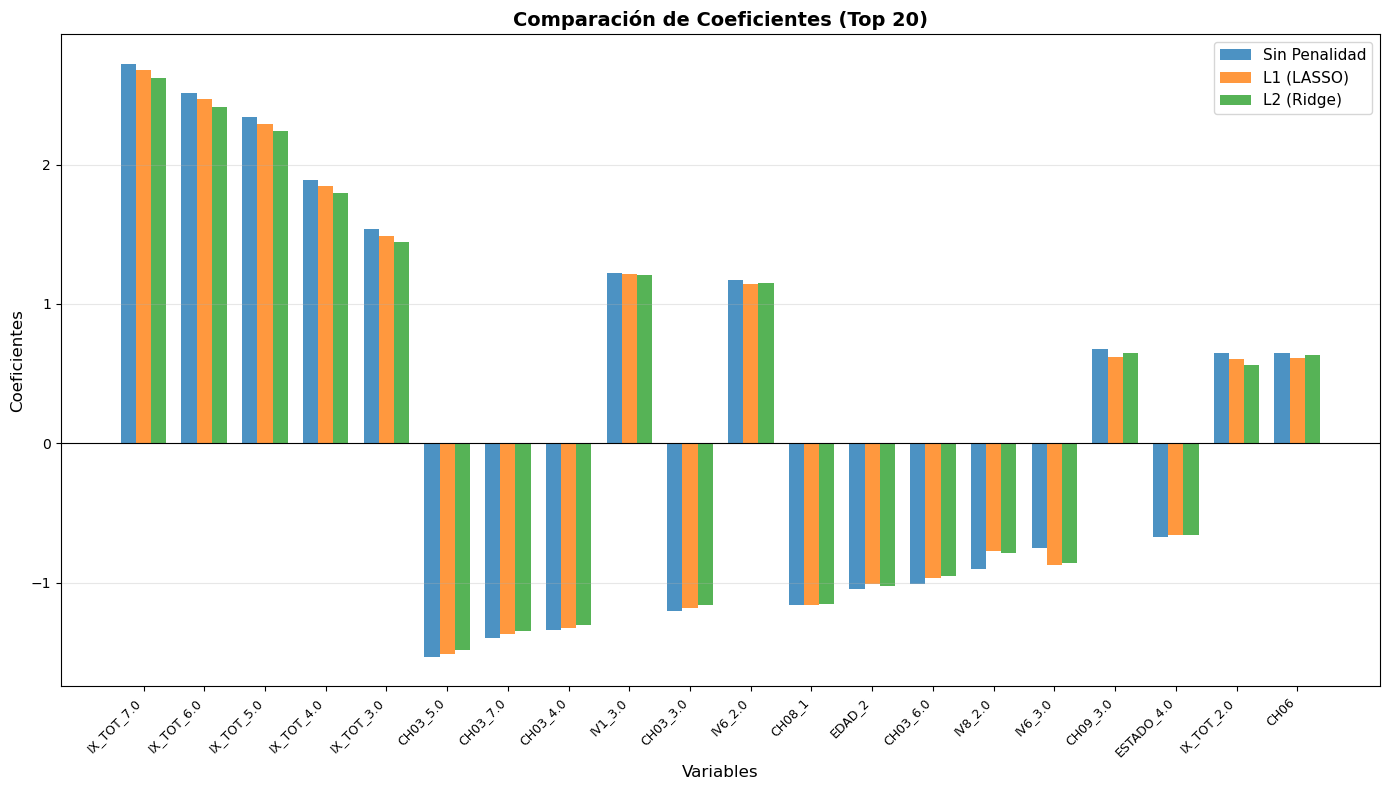


INTERPRETACIÓN DE RESULTADOS

1. COMPARACIÓN CON REGRESIÓN LOGÍSTICA SIN PENALIDAD:
------------------------------------------------------------

   Variables ELIMINADAS por L1 (coef ≈ 0): 1
   Ejemplos: ['const']

   Variables MÁS REDUCIDAS por L2:
   • const: -0.0243 → 0.0086 (35.5% del original)
   • CH07_3.0: 0.0600 → 0.0467 (77.8% del original)
   • CH07_5.0: 0.1506 → 0.1255 (83.4% del original)

2. EFECTO DE LA REGULARIZACIÓN:
------------------------------------------------------------
   • L1 (LASSO) elimina 1 de 52 variables
     → Realiza SELECCIÓN AUTOMÁTICA de variables
   • L2 (Ridge) mantiene todas las variables pero las reduce
     → NO elimina variables de X_train

3. ¿LA PENALIDAD L2 ELIMINA VARIABLES?
------------------------------------------------------------
   NO. La penalidad L2 (Ridge) NO elimina variables de X_train.
   Ridge solo REDUCE la magnitud de los coeficientes, pero nunca
   los lleva exactamente a cero. Todas las variables permanecen
   en el modelo,

In [67]:
feature_names = x_train_2025.columns.tolist()
# Modelo sin penalidad
print("\nEntrenando modelo sin penalidad...")
model_none = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
model_none.fit(x_train_2025, y_train_2025)
coef_none = model_none.coef_[0]

# Modelo L1 con lambda óptima
print("Entrenando modelo LASSO con λ óptima...")
model_l1 = LogisticRegression(C=1.0/lambda_opt_lasso, penalty='l1', 
                              solver='liblinear', max_iter=1000, random_state=42)
model_l1.fit(x_train_2025, y_train_2025)
coef_l1 = model_l1.coef_[0]

# Modelo L2 con lambda óptima
print("Entrenando modelo Ridge con λ óptima...")
model_l2 = LogisticRegression(C=1.0/lambda_opt_ridge, penalty='l2',
                              solver='liblinear', max_iter=1000, random_state=42)
model_l2.fit(x_train_2025, y_train_2025)
coef_l2 = model_l2.coef_[0]

# Crear tabla de comparación
comparison_df = pd.DataFrame({
    'Variable': feature_names,
    'Sin Penalidad': coef_none,
    'L1 (LASSO)': coef_l1,
    'L2 (Ridge)': coef_l2
})

# Ordenar por magnitud del coeficiente sin penalidad
comparison_df['Abs_Sin_Penalidad'] = np.abs(comparison_df['Sin Penalidad'])
comparison_df = comparison_df.sort_values('Abs_Sin_Penalidad', ascending=False)
comparison_df = comparison_df.drop('Abs_Sin_Penalidad', axis=1)

# EXPORTAR A CSV
comparison_df.to_csv('comparacion_coeficientes_penalidad.csv', index=False)
print("\n✓ Tabla exportada a: comparacion_coeficientes_penalidad.csv")

print("\n" + "="*80)
print("TABLA DE COEFICIENTES ESTIMADOS (Top 30)")
print("="*80)
print(comparison_df.head(30).to_string(index=False))

# GRÁFICO: 
n_top = min(20, len(feature_names))
top_vars_idx = np.argsort(np.abs(coef_none))[-n_top:][::-1]
top_feature_names = [feature_names[i] for i in top_vars_idx]

fig, ax = plt.subplots(figsize=(14, 8))

x_pos = np.arange(n_top)
width = 0.25

ax.bar(x_pos - width, coef_none[top_vars_idx], width, label='Sin Penalidad', alpha=0.8)
ax.bar(x_pos, coef_l1[top_vars_idx], width, label='L1 (LASSO)', alpha=0.8)
ax.bar(x_pos + width, coef_l2[top_vars_idx], width, label='L2 (Ridge)', alpha=0.8)
ax.set_xlabel('Variables', fontsize=12)
ax.set_ylabel('Coeficientes', fontsize=12)
ax.set_title(f'Comparación de Coeficientes (Top {n_top})', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(top_feature_names, rotation=45, ha='right', fontsize=9)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Interpretación
print("\n" + "="*80)
print("INTERPRETACIÓN DE RESULTADOS")
print("="*80)

print("\n1. COMPARACIÓN CON REGRESIÓN LOGÍSTICA SIN PENALIDAD:")
print("-" * 60)

# Variables eliminadas por L1
vars_eliminadas_l1 = [feature_names[i] for i in range(len(coef_l1)) 
                      if np.abs(coef_l1[i]) < 1e-5]
if vars_eliminadas_l1:
    print(f"\n   Variables ELIMINADAS por L1 (coef ≈ 0): {len(vars_eliminadas_l1)}")
    print(f"   Ejemplos: {vars_eliminadas_l1[:5]}")
else:
    print("\n   L1 NO eliminó ninguna variable")

# Variables más reducidas por L2
reduccion_l2 = np.abs(coef_l2) / (np.abs(coef_none) + 1e-10)
idx_mas_reducidas = np.argsort(reduccion_l2)[:3]
print(f"\n   Variables MÁS REDUCIDAS por L2:")
for idx in idx_mas_reducidas:
    if np.abs(coef_none[idx]) > 1e-5:
        print(f"   • {feature_names[idx]}: {coef_none[idx]:.4f} → {coef_l2[idx]:.4f} "
              f"({reduccion_l2[idx]*100:.1f}% del original)")

print("\n2. EFECTO DE LA REGULARIZACIÓN:")
print("-" * 60)
print(f"   • L1 (LASSO) elimina {len(vars_eliminadas_l1)} de {len(feature_names)} variables")
print(f"     → Realiza SELECCIÓN AUTOMÁTICA de variables")
print(f"   • L2 (Ridge) mantiene todas las variables pero las reduce")
print(f"     → NO elimina variables de X_train")

print("\n3. ¿LA PENALIDAD L2 ELIMINA VARIABLES?")
print("-" * 60)
print("   NO. La penalidad L2 (Ridge) NO elimina variables de X_train.")
print("   Ridge solo REDUCE la magnitud de los coeficientes, pero nunca")
print("   los lleva exactamente a cero. Todas las variables permanecen")
print("   en el modelo, aunque con coeficientes más pequeños.")
print(f"   \n   En este caso: {np.sum(np.abs(coef_l2) < 1e-5)} variables con coef ≈ 0 en L2")
print(f"                 vs {len(vars_eliminadas_l1)} variables con coef = 0 en L1")

In [68]:
comparison_df.to_csv('comparacion_coeficientes_penalidad2.xlsx', index=False)

E. Desempeño de modelos afuera de la muestra, métricas y politicas públicas

11. Comparen el desempeño de predicción de pobreza en la base de X_test en 2025 de los modelos Logit, KNN con K-CV, logit con penalidad λ^cv de LASSO y logit con λ^cv de Ridge. Muestren: 

A.          la matriz de confusión (con umbral p>0.5) para logit

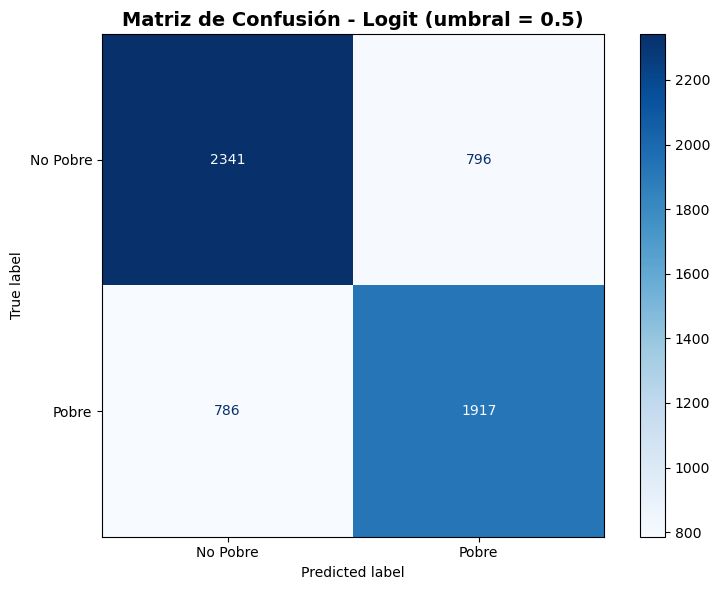


Error Tipo I (falso positivo):  0.2537 (25.37%)
Error Tipo II (falso negativo): 0.2908 (29.08%)


In [69]:
model_logit = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
model_logit.fit(x_train_2025, y_train_2025)

# Predicciones en test con umbral 0.5
y_pred_logit = model_logit.predict(x_test_2025)

# Matriz de confusión
cm_logit = confusion_matrix(y_test_2025, y_pred_logit)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logit, 
                               display_labels=['No Pobre', 'Pobre'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Matriz de Confusión - Logit (umbral = 0.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Tasas de error
total = cm_logit.sum()
error_tipo_1 = cm_logit[0,1] / (cm_logit[0,0] + cm_logit[0,1])  # FP / (TN + FP)
error_tipo_2 = cm_logit[1,0] / (cm_logit[1,0] + cm_logit[1,1])  # FN / (FN + TP)

print(f"\nError Tipo I (falso positivo):  {error_tipo_1:.4f} ({error_tipo_1*100:.2f}%)")
print(f"Error Tipo II (falso negativo): {error_tipo_2:.4f} ({error_tipo_2*100:.2f}%)")


PUNTO 1.ii: CURVA ROC - COMPARACIÓN DE MODELOS

Entrenando Logit LASSO...
Entrenando Logit Ridge...
Usando KNN con K óptimo = 10


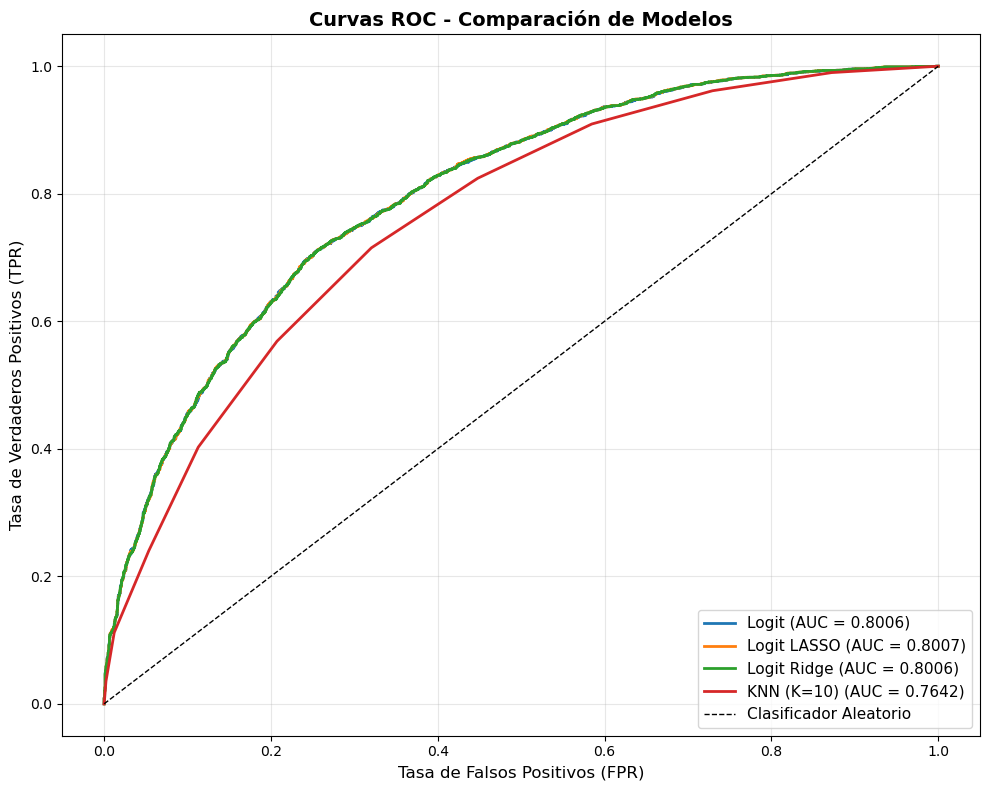


Modelo               AUC       
------------------------------
Logit                0.8006    
Logit LASSO          0.8007    
Logit Ridge          0.8006    
KNN (K={best_k})     0.7642    


In [70]:
print("\n" + "="*60)
print("PUNTO 1.ii: CURVA ROC - COMPARACIÓN DE MODELOS")
print("="*60)

# 1. Logit (ya entrenado)
y_proba_logit = log_reg.predict_proba(x_test_2025)[:, 1]

# 2. Logit LASSO
print("\nEntrenando Logit LASSO...")
model_lasso = LogisticRegression(C=1.0/lambda_opt_lasso, penalty='l1', 
                                 solver='liblinear', max_iter=1000, random_state=42)
model_lasso.fit(x_train_2025, y_train_2025)
y_proba_lasso = model_lasso.predict_proba(x_test_2025)[:, 1]

# 3. Logit Ridge
print("Entrenando Logit Ridge...")
model_ridge = LogisticRegression(C=1.0/lambda_opt_ridge, penalty='l2',
                                 solver='liblinear', max_iter=1000, random_state=42)
model_ridge.fit(x_train_2025, y_train_2025)
y_proba_ridge = model_ridge.predict_proba(x_test_2025)[:, 1]

# 4. KNN con K óptimo (usar el best_k que ya calculaste)
print(f"Usando KNN con K óptimo = {best_k}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(x_train_2025, y_train_2025)
y_proba_knn = model_knn.predict_proba(x_test_2025)[:, 1]

# Calcular ROC para cada modelo
fpr_logit, tpr_logit, _ = roc_curve(y_test_2025, y_proba_logit)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test_2025, y_proba_lasso)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test_2025, y_proba_ridge)
fpr_knn, tpr_knn, _ = roc_curve(y_test_2025, y_proba_knn)

auc_logit = auc(fpr_logit, tpr_logit)
auc_lasso = auc(fpr_lasso, tpr_lasso)
auc_ridge = auc(fpr_ridge, tpr_ridge)
auc_knn = auc(fpr_knn, tpr_knn)

# Graficar
plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, linewidth=2, label=f'Logit (AUC = {auc_logit:.4f})')
plt.plot(fpr_lasso, tpr_lasso, linewidth=2, label=f'Logit LASSO (AUC = {auc_lasso:.4f})')
plt.plot(fpr_ridge, tpr_ridge, linewidth=2, label=f'Logit Ridge (AUC = {auc_ridge:.4f})')
plt.plot(fpr_knn, tpr_knn, linewidth=2, label=f'KNN (K={best_k}) (AUC = {auc_knn:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador Aleatorio')

plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'Modelo':<20} {'AUC':<10}")
print("-"*30)
print(f"{'Logit':<20} {auc_logit:<10.4f}")
print(f"{'Logit LASSO':<20} {auc_lasso:<10.4f}")
print(f"{'Logit Ridge':<20} {auc_ridge:<10.4f}")
print(f"{'KNN (K={best_k})':<20} {auc_knn:<10.4f}")

iii.	un tabla con dos métricas de clasificación vista en clase de los cuatro modelos, e interprete los resultados.

In [71]:
print("\n" + "="*60)
print("PUNTO 1.iii: MÉTRICAS DE CLASIFICACIÓN")
print("="*60)

# Predicciones para cada modelo
y_pred_logit = log_reg.predict(x_test_2025)
y_pred_lasso = model_lasso.predict(x_test_2025)
y_pred_ridge = model_ridge.predict(x_test_2025)
y_pred_knn = model_knn.predict(x_test_2025)

# Calcular métricas
modelos = ['Logit', 'Logit LASSO', 'Logit Ridge', f'KNN (K={best_k})']
predicciones = [y_pred_logit, y_pred_lasso, y_pred_ridge, y_pred_knn]

metricas_df = pd.DataFrame({
    'Modelo': modelos,
    'Precision': [round(precision_score(y_test_2025, pred), 3) for pred in predicciones],
    'Recall': [round(recall_score(y_test_2025, pred), 3) for pred in predicciones],
})

print("\nTabla de Métricas:")
print(metricas_df.to_string(index=False))

# Exportar a CSV
metricas_df.to_csv('metricas_comparacion_modelos3.csv', index=False)

# Mejor modelo por métrica
print("\n" + "-"*60)
print("MEJOR MODELO POR MÉTRICA:")
print("-"*60)
for col in [ 'Precision', 'Recall']:
    idx_max = metricas_df[col].idxmax()
    print(f"• {col}: {metricas_df.loc[idx_max, 'Modelo']} ({metricas_df.loc[idx_max, col]:.4f})")


PUNTO 1.iii: MÉTRICAS DE CLASIFICACIÓN

Tabla de Métricas:
     Modelo  Precision  Recall
      Logit      0.707   0.709
Logit LASSO      0.706   0.708
Logit Ridge      0.706   0.708
 KNN (K=10)      0.703   0.569

------------------------------------------------------------
MEJOR MODELO POR MÉTRICA:
------------------------------------------------------------
• Precision: Logit (0.7070)
• Recall: Logit (0.7090)


In [72]:
# Calcular Recall para cada modelo
recalls = metricas_df[['Modelo', 'Recall']].sort_values('Recall', ascending=False)

print("\n" + "-"*60)
print("MODELOS ORDENADOS POR RECALL:")
print("-"*60)
print(recalls.to_string(index=False))

# Seleccionar el mejor
mejor_modelo_nombre = recalls.iloc[0]['Modelo']
mejor_recall = recalls.iloc[0]['Recall']

print("\n" + "="*60)
print(f"MODELO SELECCIONADO: {mejor_modelo_nombre}")
print("="*60)
print(f"• Recall (TPR):    {mejor_recall:.4f} → Identifica {mejor_recall*100:.1f}% de los pobres reales")
print(f"\nEste modelo minimiza el riesgo de dejar sin ayuda a población vulnerable,")
print(f"que es el error más grave en contexto de política social.")

# Determinar qué objeto usar
if 'Logit LASSO' in mejor_modelo_nombre:
    mejor_modelo_obj = model_lasso
elif 'Logit Ridge' in mejor_modelo_nombre:
    mejor_modelo_obj = model_ridge
elif 'KNN' in mejor_modelo_nombre:
    mejor_modelo_obj = model_knn
else:
    mejor_modelo_obj = model_logit


------------------------------------------------------------
MODELOS ORDENADOS POR RECALL:
------------------------------------------------------------
     Modelo  Recall
      Logit   0.709
Logit LASSO   0.708
Logit Ridge   0.708
 KNN (K=10)   0.569

MODELO SELECCIONADO: Logit
• Recall (TPR):    0.7090 → Identifica 70.9% de los pobres reales

Este modelo minimiza el riesgo de dejar sin ayuda a población vulnerable,
que es el error más grave en contexto de política social.


13.	Con el método que seleccionaron, predigan qué personas son pobres dentro de la base norespondieron para 2025. ¿Qué proporción de las personas que no respondieron pudieron identificar como pobres? 


PUNTO 3: PREDICCIÓN EN NO RESPONDIERON

Usando modelo: Logit (seleccionado en punto 2)

------------------------------------------------------------
RESULTADOS EN NO RESPONDIERON:
------------------------------------------------------------
• Total de personas que no respondieron: 995
• Personas identificadas como pobres:    457
• Proporción de pobres:                0.4593 (45.93%)

------------------------------------------------------------
DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS:
------------------------------------------------------------
• Media:    0.4697
• Mediana:  0.4603
• Mínimo:   0.0073
• Máximo:   0.9836


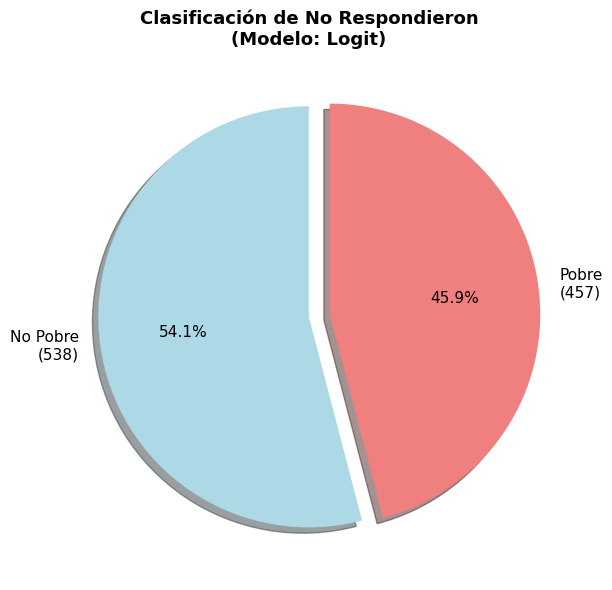

In [75]:
print("\n" + "="*60)
print("PUNTO 3: PREDICCIÓN EN NO RESPONDIERON")
print("="*60)

print(f"\nUsando modelo: {mejor_modelo_nombre} (seleccionado en punto 2)")

# Predecir en no_respondieron_2025
##agregamos la constante
df_noresp_25 = sm.add_constant(df_noresp_25, prepend=True)

y_pred_no_resp = mejor_modelo_obj.predict(df_noresp_25)
y_proba_no_resp = mejor_modelo_obj.predict_proba(df_noresp_25)[:, 1]

# Calcular proporción de pobres identificados
n_total_no_resp = len(y_pred_no_resp)
n_pobres_pred = np.sum(y_pred_no_resp == 1)
prop_pobres = n_pobres_pred / n_total_no_resp

print("\n" + "-"*60)
print("RESULTADOS EN NO RESPONDIERON:")
print("-"*60)
print(f"• Total de personas que no respondieron: {n_total_no_resp:,}")
print(f"• Personas identificadas como pobres:    {n_pobres_pred:,}")
print(f"• Proporción de pobres:                {prop_pobres:.4f} ({prop_pobres*100:.2f}%)")

# Distribución de probabilidades
print("\n" + "-"*60)
print("DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS:")
print("-"*60)
print(f"• Media:    {y_proba_no_resp.mean():.4f}")
print(f"• Mediana:  {np.median(y_proba_no_resp):.4f}")
print(f"• Mínimo:   {y_proba_no_resp.min():.4f}")
print(f"• Máximo:   {y_proba_no_resp.max():.4f}")

# --- Visualización (MODIFICADA) ---
# Se eliminó el histograma (axes[0]) y se usa un solo eje (ax)

# Crear la figura y un solo eje
fig, ax = plt.subplots(figsize=(7, 6)) # Tamaño ajustado para un solo gráfico

# Pie chart de clasificación
sizes = [n_total_no_resp - n_pobres_pred, n_pobres_pred]
labels = [f'No Pobre\n({sizes[0]:,})', f'Pobre\n({sizes[1]:,})']
colors = ['lightblue', 'lightcoral']
explode = (0, 0.1) # Resaltar la porción "Pobre"

ax.pie(sizes, 
       explode=explode, 
       labels=labels, 
       colors=colors, 
       autopct='%1.1f%%',
       shadow=True, 
       startangle=90, 
       textprops={'fontsize': 11})

ax.set_title(f'Clasificación de No Respondieron\n(Modelo: {mejor_modelo_nombre})', 
             fontsize=13, 
             fontweight='bold')

plt.tight_layout()
plt.show()
